In [1]:
import requests
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Group: cvssV3Severity=LOW
Count for windows is: 73
Count for macOS is: 54
Count for iOS is: 121
Count for android is: 154
Total count of cvssV3Severity=LOW is 402

The ratio of matching keyword vulnerablities is: 40.547263681592035%

Group: cvssV3Severity=MEDIUM
Count for windows is: 1704
Count for macOS is: 595
Count for iOS is: 1444
Count for android is: 2028
Total count of cvssV3Severity=MEDIUM is 5743

The ratio of matching keyword vulnerablities is: 22.47954030994254%

Group: cvssV3Severity=HIGH
Count for windows is: 4023
Count for macOS is: 1156
Count for iOS is: 1853
Count for android is: 2963
Total count of cvssV3Severity=HIGH is 7009

The ratio of matching keyword vulnerablities is: 13.668140961620773%

Group: cvssV3Severity=CRITICAL
Count for windows is: 633
Count for macOS is: 147
Count for iOS is: 239
Count for android is: 731
Total count of cvssV3Severity=CRITICAL is 1750

The ratio of matching keyword vulnerablities is: 18.74285714285714%



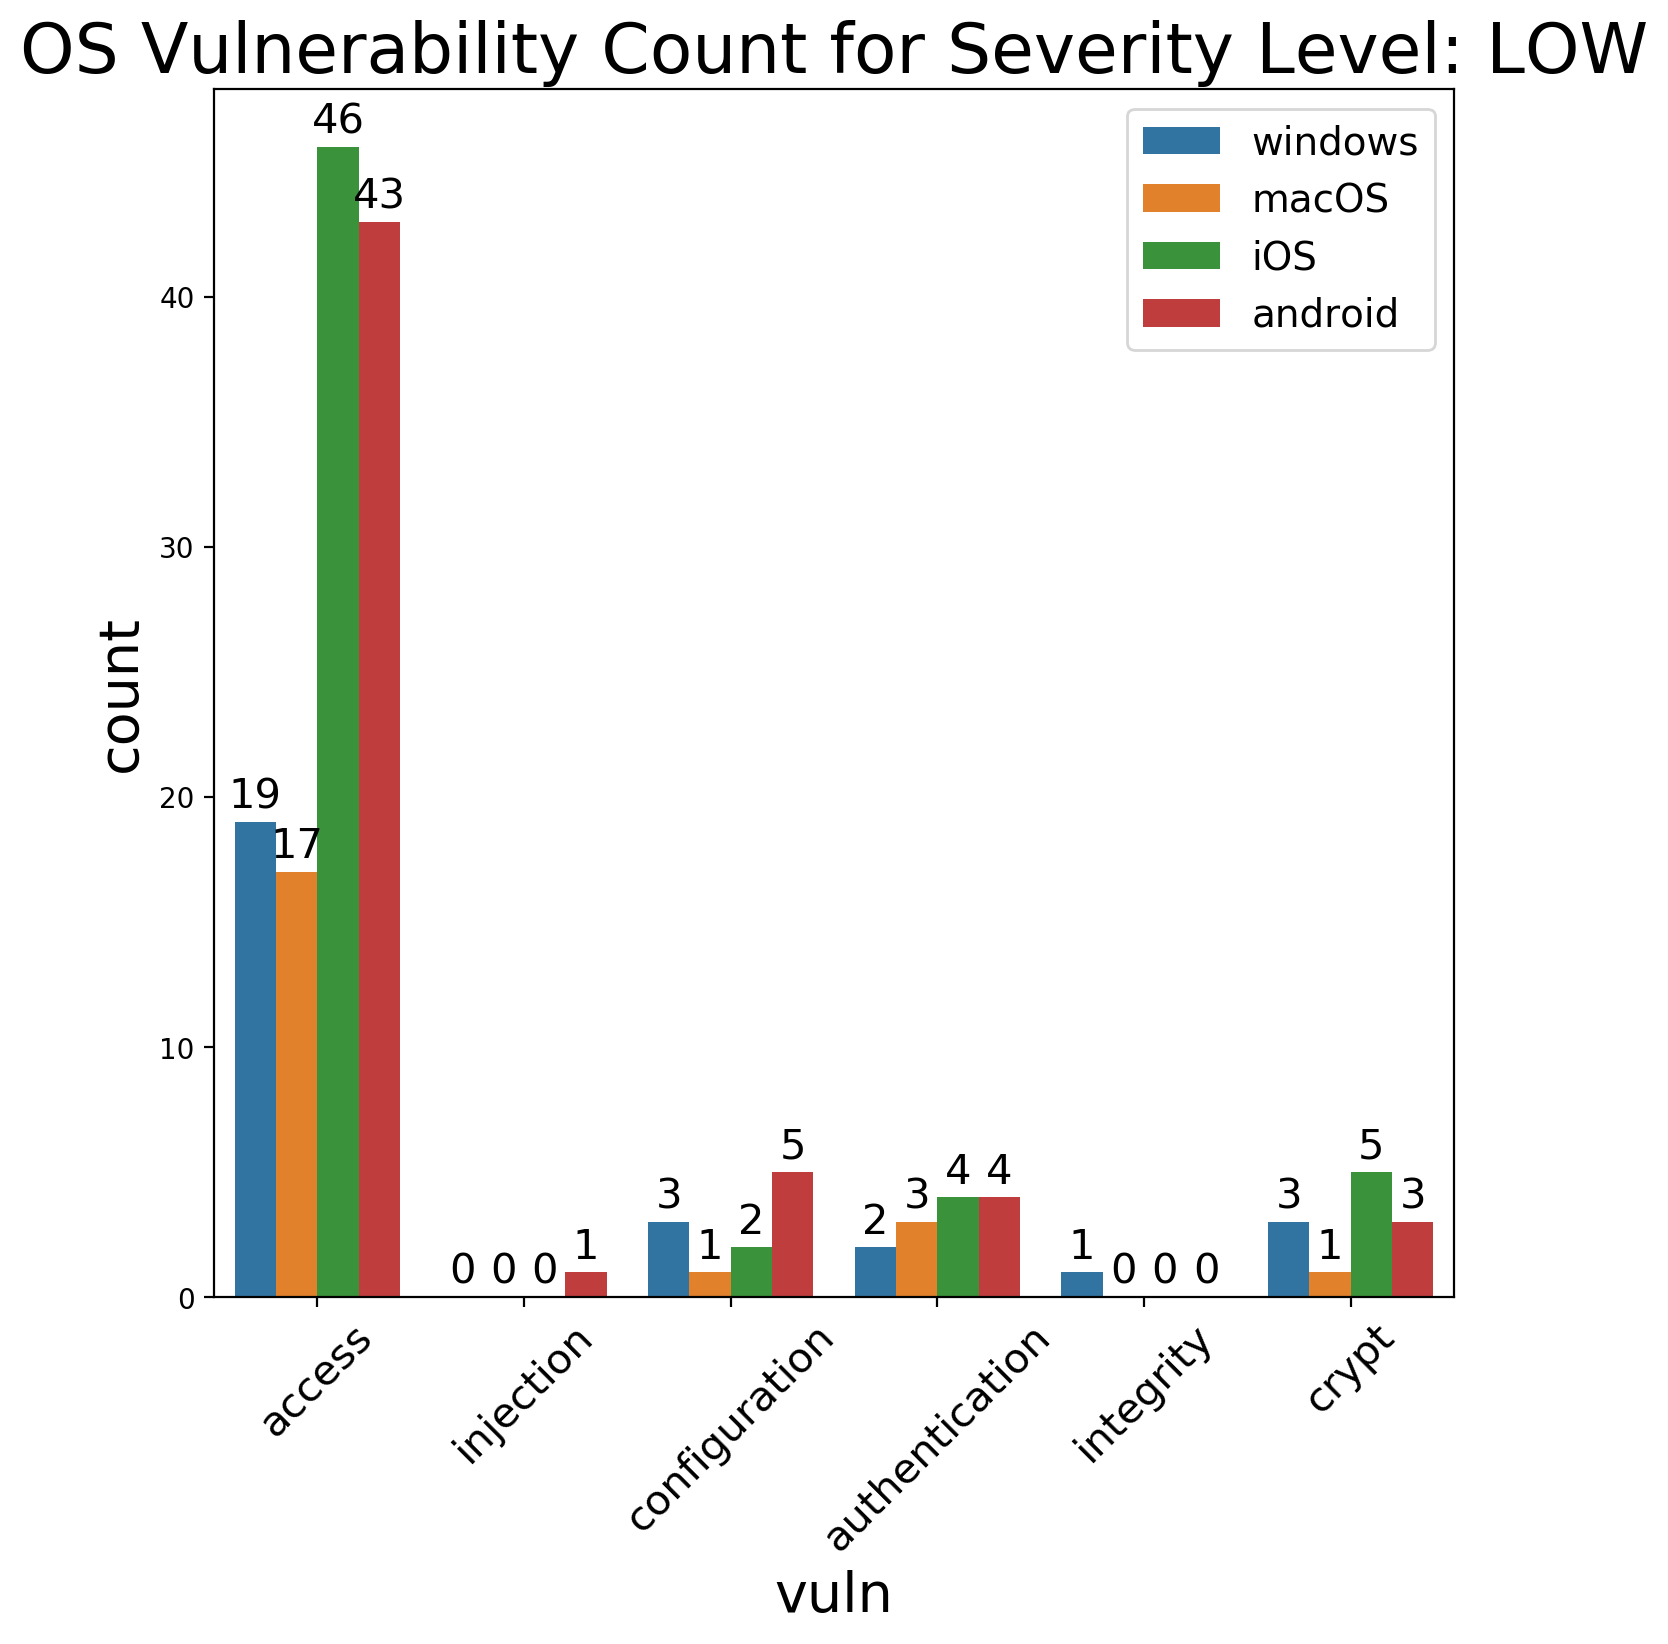

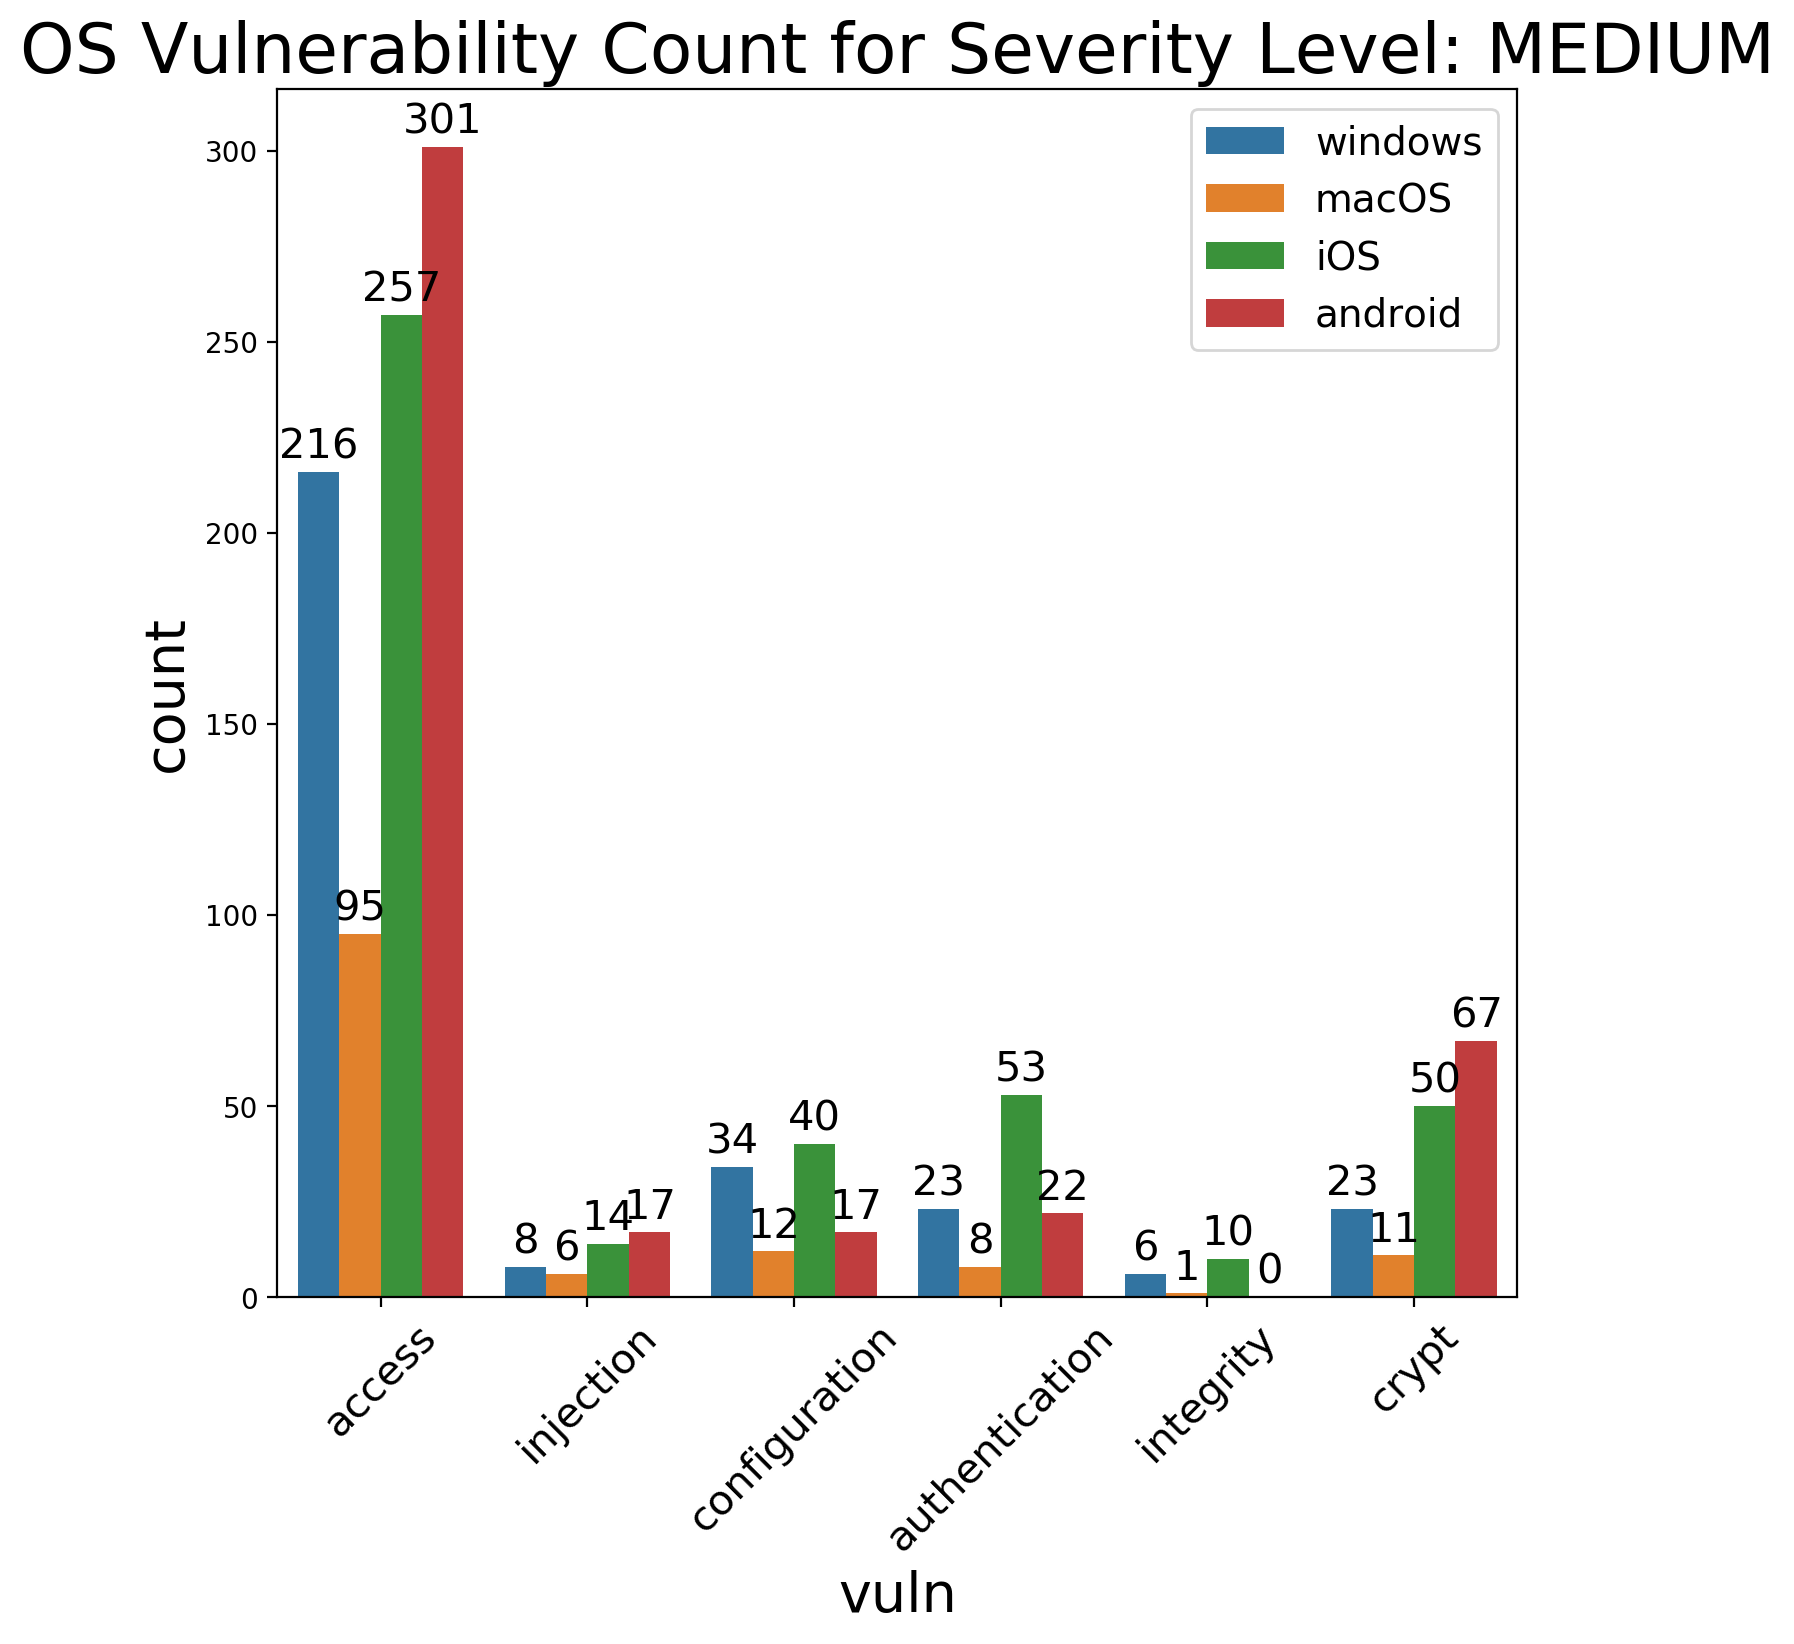

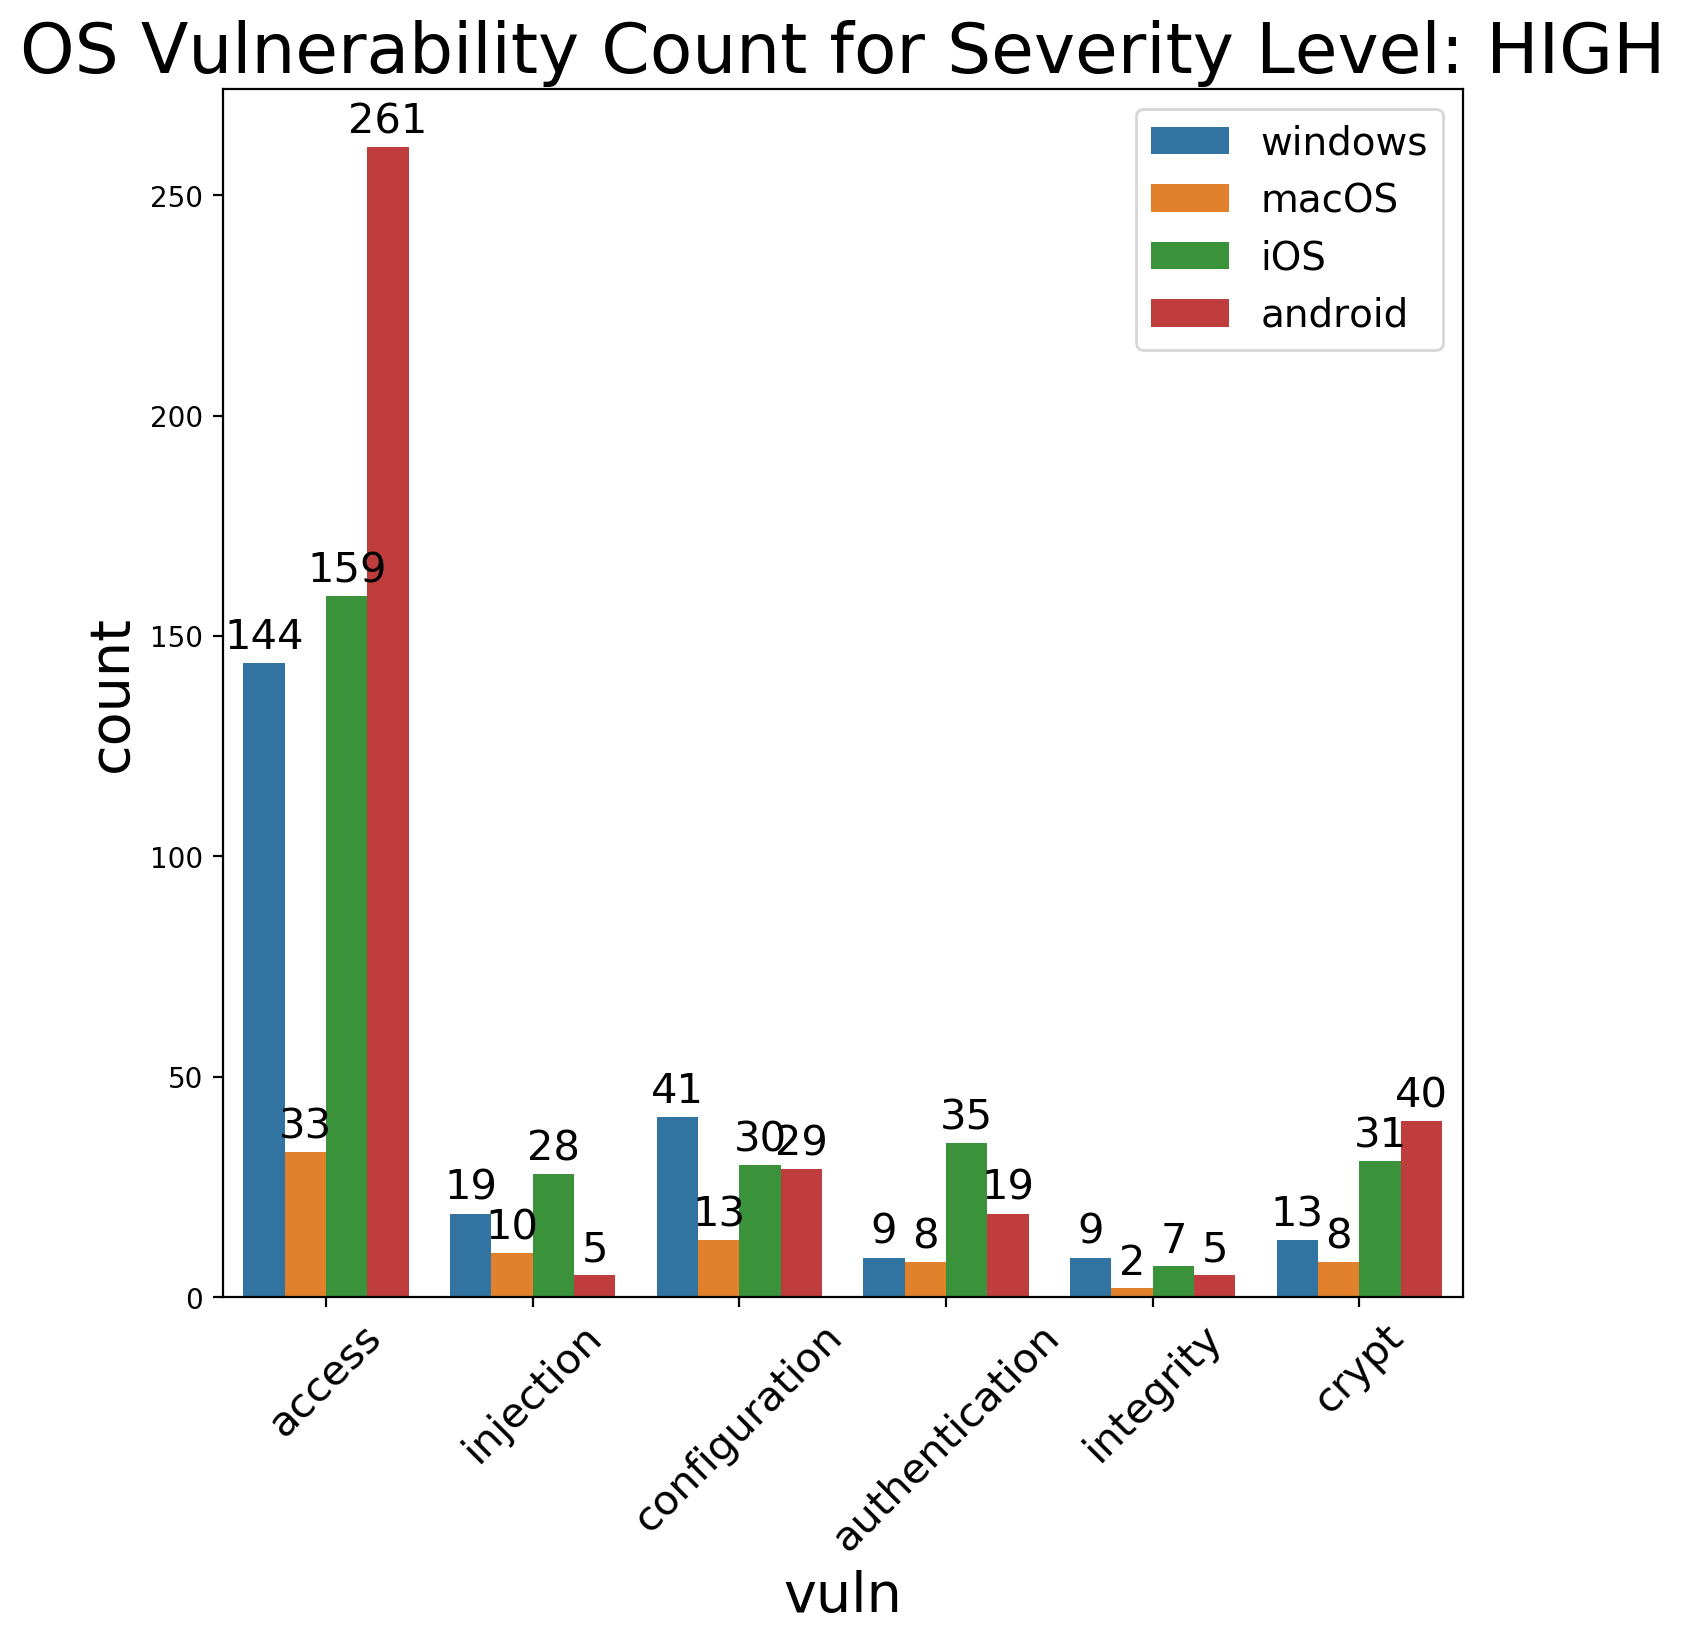

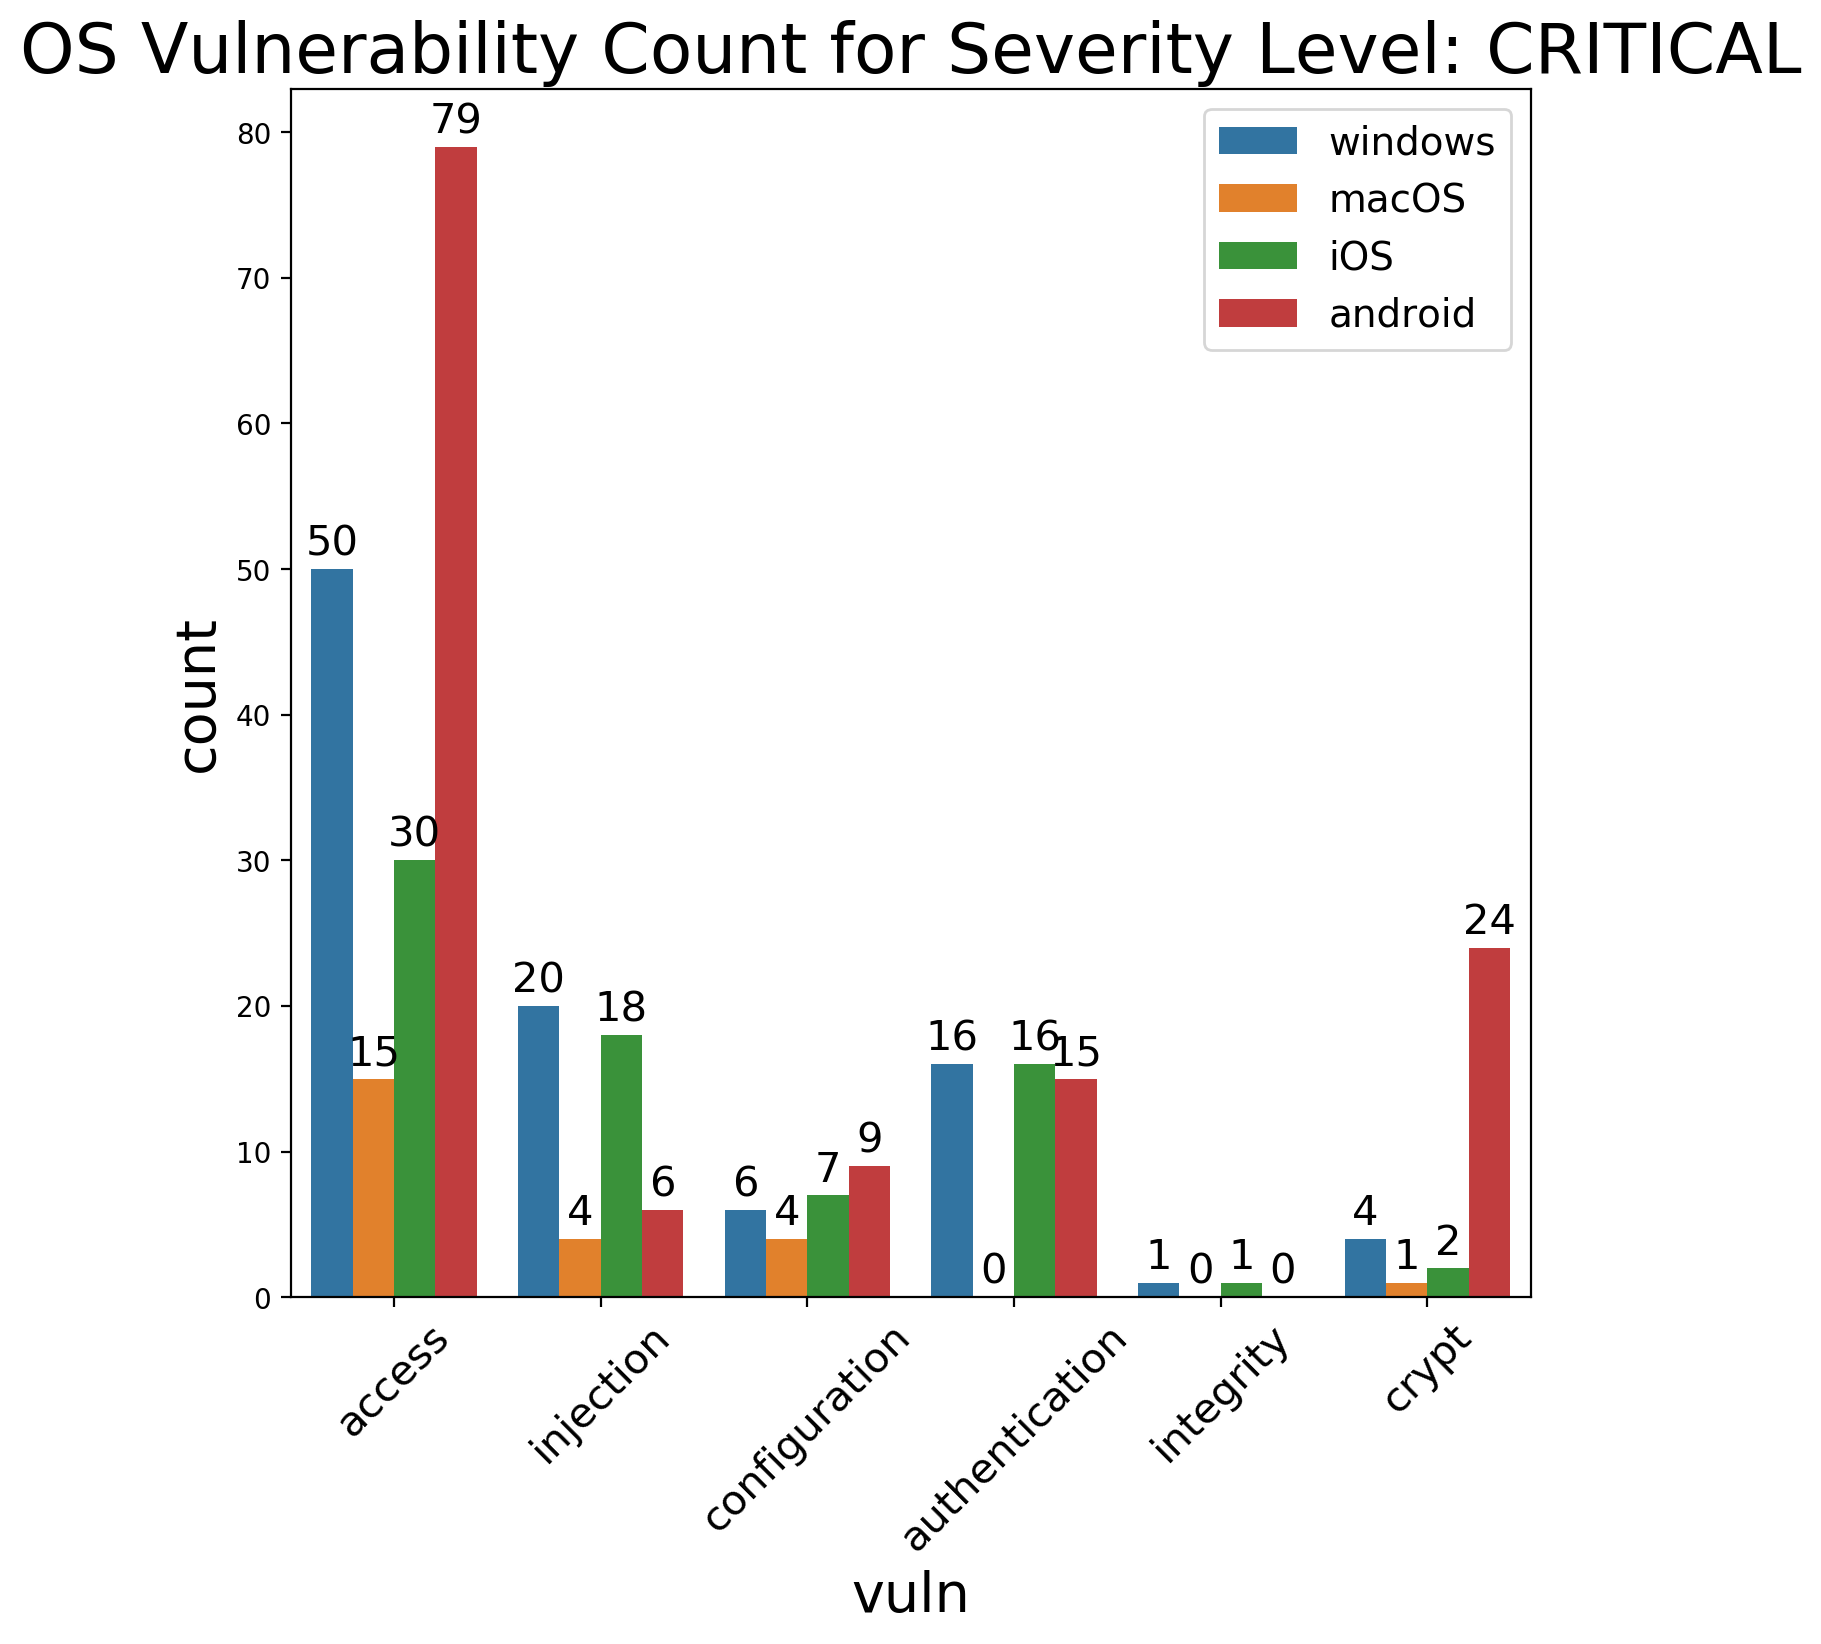

<Figure size 1200x800 with 0 Axes>

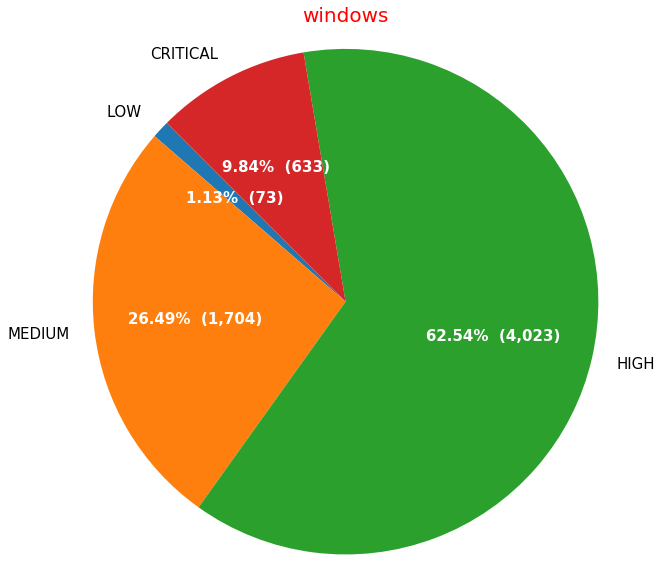

<Figure size 1200x800 with 0 Axes>

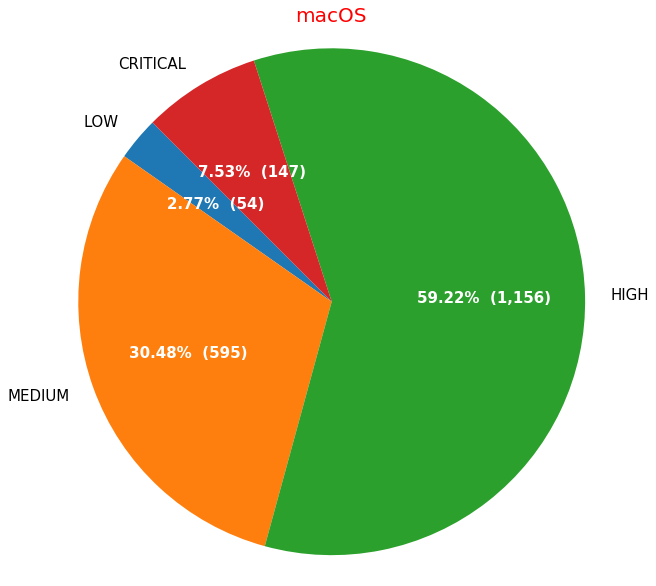

<Figure size 1200x800 with 0 Axes>

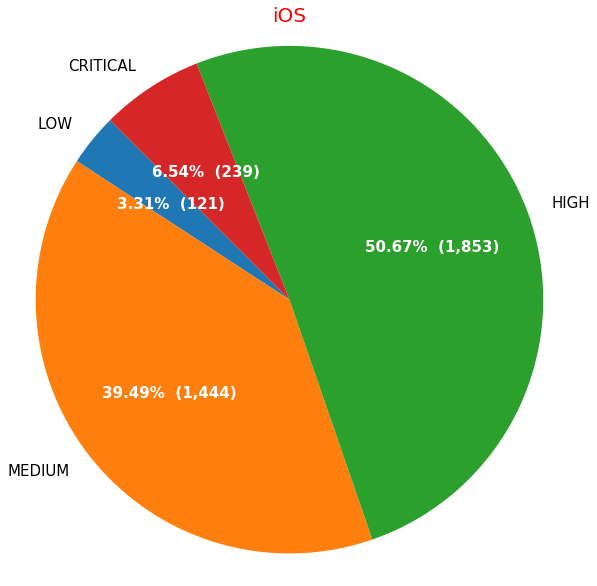

<Figure size 1200x800 with 0 Axes>

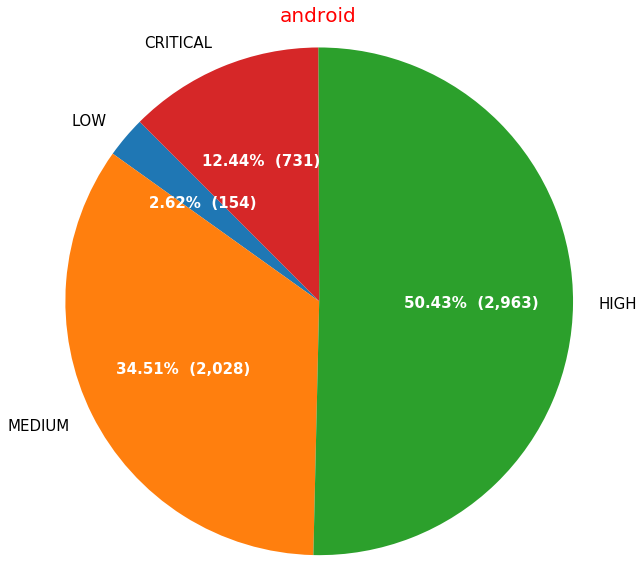

In [2]:
#cleaned up code

sev_list = ['LOW','MEDIUM','HIGH','CRITICAL']#,'MEDIUM',HIGH']

api_base = 'https://services.nvd.nist.gov/rest/json/cves/1.0?'
severity = 'cvssV3Severity='
keyword = '&keyword=' #macOS iOS Android'
os_list = ['windows','macOS','iOS','android'] #,'macOS','iOS','android']
isExactMatch = '&isExactMatch=true'
resultsPerPage = '&resultsPerPage=2000'

all_values = []

for sev in sev_list: 
    tl_count = 0
    total_list = []

    print('Group: ' + severity + sev)
    for os in os_list:  
        response = requests.get(api_base + severity + sev + keyword + os + isExactMatch + resultsPerPage)
        data = response.json()
        print('Count for ' + os + ' is: ' + str(data['totalResults']))
        all_values.append(int(data['totalResults']))

        if data['totalResults'] < 2000: 
            tl_count = tl_count + int(data['totalResults'])
            count = 0
            while count < data['totalResults']: #data['totalResults']:
                inner_list = []
                description = data['result']['CVE_Items'][count]['cve']['description']['description_data'][0]['value']
                date = data['result']['CVE_Items'][count]['publishedDate']

                inner_list.append(description)
                inner_list.append(date[0:7])
                inner_list.append(os)
                total_list.append(inner_list)
                count+=1
        
        else: 
            tl_count = tl_count + 2000
            count = 0
            while count < 2000: #data['totalResults']:
                inner_list = []
                description = data['result']['CVE_Items'][count]['cve']['description']['description_data'][0]['value']
                date = data['result']['CVE_Items'][count]['publishedDate']

                inner_list.append(description)
                inner_list.append(date[0:7])
                inner_list.append(os)
                total_list.append(inner_list)
                count+=1

    print('Total count of ' + severity + sev + ' is ' + str(tl_count))
    print()

    
    #create df and check for matching keyword vulnerabilities 
    df = pd.DataFrame(total_list, columns=['description','date','os'])
    vuln_list = ['access','injection','configuration','authentication','integrity','crypt']
    header_list = ['description','date','os','access','injection','configuration','authentication','integrity','crypt']
    df = df.reindex(columns = header_list)
    df = df.replace(np.nan,0)

    tc = 0
    count = 0
    while count < len(total_list): 
        for vuln in vuln_list: 
            if vuln in df['description'].iloc[count]:
                df.at[count,vuln] = 1
                tc+=1
        count+=1
        
    
    test = df.groupby(['os']).sum()
    graph_df = pd.DataFrame(columns=['os','vuln','count'])

    for os in os_list:
        for vuln in vuln_list: 
            graph_df = graph_df.append({'os':os, 'vuln':vuln, 'count':int(test[vuln][os])},ignore_index=True)
    #graph_df
        
    plt.figure(figsize=(8,8),dpi=200)
    
    #to view the opposite bar chart, switch x and hue values, ex: x = 'os' and hue='vuln'
    chart = sns.barplot(data=graph_df,x='vuln',y='count',hue='os')

    for p in chart.patches:
        chart.annotate(format(p.get_height(), '.0f'), 
                       (p.get_x() + p.get_width()/2, p.get_height()), 
                       ha = 'center', va = 'center', 
                       size=15,
                       xytext = (0, 9), 
                       textcoords = 'offset points')
    plt.legend(loc='upper right',prop={'size': 14})

    chart.set_xticklabels(chart.get_xmajorticklabels(), rotation=45, fontsize = 15)
    chart.set_xlabel(chart.get_xlabel(), fontsize = 20)
    chart.set_ylabel(chart.get_ylabel(), fontsize = 20)

    #plt.text(0.1, 2.8, "The gradient is {}, the intercept is {}".format(m, c))
    plt.title("OS Vulnerability Count for Severity Level: {}".format(sev), fontsize = 25)

    print('The ratio of matching keyword vulnerablities is: ' + str((tc/tl_count*100)) + '%')
    print()
    
    
#create some pie charts for each OS and split between severity levels 
windows_values = all_values[0::4]
macOS_values = all_values[1::4]
iOS_values = all_values[2::4]
android_values = all_values[3::4]

#windows
plt.figure(dpi=200)  #increase quality
fig1, ax1 = plt.subplots(figsize=(8,8))
patches, texts, autotexts = ax1.pie(windows_values, labels=sev_list, autopct=lambda p : '{:.2f}%  ({:,.0f})'.format(p,p * sum(windows_values)/100), startangle=135)
for text in texts:  #outer text manipulation
    text.set_color('black')
    text.set_fontsize(15)
for autotext in autotexts: #inner text manipulation
    autotext.set_color('w')
    autotext.set_fontsize(15)
    autotext.set_fontweight('bold')
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()

plt.title(f'{os_list[0]}',size=20,color = 'red')
plt.show()

#macOS
plt.figure(dpi=200)  #increase quality
fig1, ax1 = plt.subplots(figsize=(8,8))
patches, texts, autotexts = ax1.pie(macOS_values, labels=sev_list, autopct=lambda p : '{:.2f}%  ({:,.0f})'.format(p,p * sum(macOS_values)/100), startangle=135)
for text in texts:  #outer text manipulation
    text.set_color('black')
    text.set_fontsize(15)
for autotext in autotexts: #inner text manipulation
    autotext.set_color('w')
    autotext.set_fontsize(15)
    autotext.set_fontweight('bold')
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()

plt.title(f'{os_list[1]}',size=20,color = 'red')
plt.show()

#iOS
plt.figure(dpi=200)  #increase quality
fig1, ax1 = plt.subplots(figsize=(8,8))
patches, texts, autotexts = ax1.pie(iOS_values, labels=sev_list, autopct=lambda p : '{:.2f}%  ({:,.0f})'.format(p,p * sum(iOS_values)/100), startangle=135)
for text in texts:  #outer text manipulation
    text.set_color('black')
    text.set_fontsize(15)
for autotext in autotexts: #inner text manipulation
    autotext.set_color('w')
    autotext.set_fontsize(15)
    autotext.set_fontweight('bold')
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()

plt.title(f'{os_list[2]}',size=20,color = 'red')
plt.show()

#android
plt.figure(dpi=200)  #increase quality
fig1, ax1 = plt.subplots(figsize=(8,8))
patches, texts, autotexts = ax1.pie(android_values, labels=sev_list, autopct=lambda p : '{:.2f}%  ({:,.0f})'.format(p,p * sum(android_values)/100), startangle=135)
for text in texts:  #outer text manipulation
    text.set_color('black')
    text.set_fontsize(15)
for autotext in autotexts: #inner text manipulation
    autotext.set_color('w')
    autotext.set_fontsize(15)
    autotext.set_fontweight('bold')
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()

plt.title(f'{os_list[3]}',size=20,color = 'red')
plt.show()    